# Calibration Verifications Using QuTiP.
This notebook aims to provide an intution-building tool into the physical aspect of quantum computing, specifically for superconducting qubits platform.

In [30]:
import qutip as qt
from matplotlib import pyplot as plt
from joblib import Parallel, delayed
import scqubits as scq
import numpy as np
from tqdm import tqdm
v_Mhz = 2*np.pi*1e6

## Frequency Domain
In this section, we analyze the frequency domain properties of the quantum system.

In [2]:
def pulse_env(t, t0, plateau, width):
    omega_ramp = 2 * np.pi / (4 * width) if width != 0 else 0
    return (
        (t0 + width < t < t0 + plateau + width)
        + (t0 <= t <= t0 + width) * (-np.cos(omega_ramp * (t - t0)) ** 2 + 1)
        + (t0 + plateau + width <= t <= t0 + plateau + 2 * width)
        * (-np.cos(omega_ramp * (t - (t0 + plateau + 2 * width))) ** 2 + 1)
    )

In [3]:
q_levels = 5
r_levels = 5

r_op = qt.tensor(qt.qeye(q_levels), qt.destroy(r_levels)).to("CSR")
q_op = qt.tensor(qt.destroy(q_levels), qt.qeye(r_levels)).to("CSR")

q_freq = 5.5 * 1e3 * v_Mhz
r_freq = 6.5 * 1e3 * v_Mhz

EC = 275 * v_Mhz
EJ = (q_freq + EC) ** 2 / 8 / EC

H_Q = scq.Transmon(EC=EC, EJ=EJ, ng=0.0, ncut=100, truncated_dim=q_levels)
H_R = scq.Oscillator(E_osc=r_freq, truncated_dim=r_levels)
H_QR = scq.HilbertSpace([H_Q, H_R])

g = 100 * v_Mhz

H_QR.add_interaction(qobj=-g * (r_op.dag() @ q_op + r_op @ q_op.dag()))

H_QR = H_QR.hamiltonian().to("CSR")

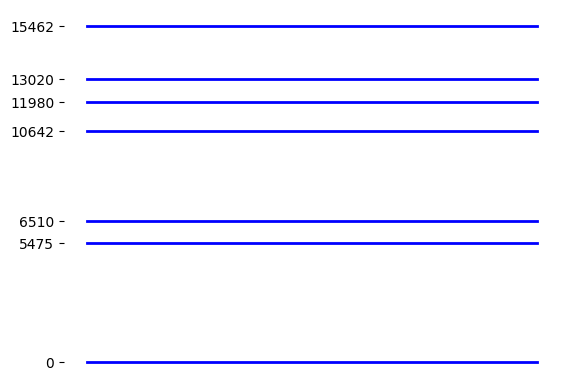

In [4]:
qt.plot_energy_levels([(qt.Qobj(np.diag(H_QR.eigenenergies()))-qt.Qobj(np.diag(H_QR.eigenenergies())).eigenenergies()[0])/v_Mhz], N=7)
plt.show()

In [5]:
q_freq = H_QR.eigenenergies()[1]-H_QR.eigenenergies()[0]
r_freq = H_QR.eigenenergies()[2]-H_QR.eigenenergies()[0]

### Resonator Spectroscopy
This subsection focuses on resonator spectroscopy, where we sweep the probe frequency to find resonator resonance.

In [6]:
freq_sweep = np.linspace(r_freq - 50*v_Mhz, r_freq+50*v_Mhz, 51)

plateau = 50e-9
width = 10e-9

tlist = np.arange(0,plateau + 2*width, 1e-9)

amp = 5*v_Mhz

H_r_drive = lambda omega_drive : qt.QobjEvo([amp * (r_op + r_op.dag()), lambda t: np.cos(omega_drive * t) * pulse_env(t, 0, plateau, width)])
H_r_drive = lambda omega_drive : [amp * (r_op + r_op.dag()), lambda t: np.cos(omega_drive * t) * pulse_env(t, 0, plateau, width)]

rho_g = qt.tensor(qt.basis(q_levels, 0), qt.basis(r_levels, 0))


In [7]:
output_one_tone = np.array(list(
    tqdm(
        Parallel(n_jobs=-1, return_as="generator")(
            delayed(qt.mesolve)(
                [H_QR,H_r_drive(omega_drive)]
                ,
                rho_g,
                tlist,
                c_ops=[],
                e_ops=[r_op.dag()@r_op],
            )
            for omega_drive in freq_sweep
        ),
        total=len(freq_sweep),
    ))).reshape(len(freq_sweep))

r_N_photons_one_tone = [output_one_tone[k].expect[0][-1] for k in range(len(freq_sweep))]


100%|██████████| 51/51 [00:04<00:00, 12.15it/s]


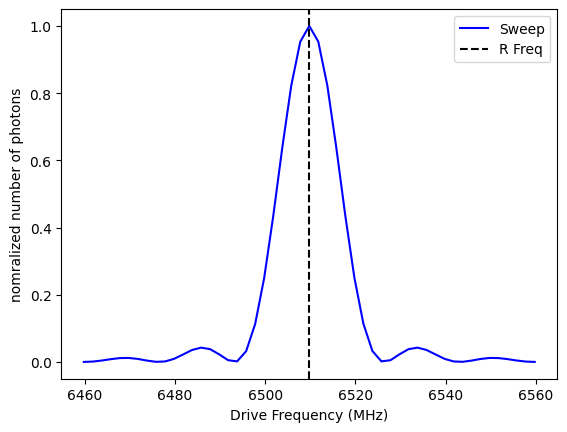

In [8]:
plt.plot(freq_sweep/v_Mhz, r_N_photons_one_tone/np.max(r_N_photons_one_tone), 'b', label = r'Sweep')
plt.axvline(r_freq/v_Mhz, c='k', linestyle = '--', label = 'R Freq')
plt.xlabel('Drive Frequency (MHz)')
plt.ylabel('nomralized number of photons')
plt.legend()
plt.show()

### Two-Tone
Here, we perform a two-tone spectroscopy to find the qubit frequency.

In [9]:
freq_sweep = np.linspace(r_freq - 30*v_Mhz, r_freq+30*v_Mhz, 51)
ctrl_sweep = np.linspace(q_freq - 50*v_Mhz, q_freq+50*v_Mhz, 36)

plateau = 50e-9
width = 10e-9

tlist = np.arange(0,2*(plateau + 2*width), 1e-9)

amp = 5*v_Mhz

H_r_drive = lambda omega_drive : [amp * (r_op + r_op.dag()), lambda t: np.cos(omega_drive * t) * pulse_env(t, (plateau + 2*width), plateau, width)]
H_q_drive = lambda omega_drive : [amp * (q_op + q_op.dag()), lambda t: np.cos(omega_drive * t) * pulse_env(t, 0, plateau, width)]

rho_g = qt.tensor(qt.basis(q_levels, 0), qt.basis(r_levels, 0))
rho_e = qt.tensor(qt.basis(q_levels, 1), qt.basis(r_levels, 0))

In [10]:
output_all = np.array(list(
    tqdm(
        Parallel(n_jobs=-1, return_as="generator")(
            delayed(qt.mesolve)(
                [H_QR,H_r_drive(omega_r_drive), H_q_drive(omega_q_drive)]
                ,
                rho_g,
                tlist,
                c_ops=[],
                e_ops=[r_op.dag()@r_op],
            )
            for omega_q_drive in ctrl_sweep
            for omega_r_drive in freq_sweep
        ),
        total=len(ctrl_sweep)*len(freq_sweep),
    ))).reshape(len(ctrl_sweep), len(freq_sweep))
n_photons_all = np.array([output_all[c,r].expect[0][-1] for c in range(len(ctrl_sweep)) for r in range(len(freq_sweep))]).reshape(len(ctrl_sweep), len(freq_sweep))

100%|██████████| 1836/1836 [04:40<00:00,  6.55it/s]


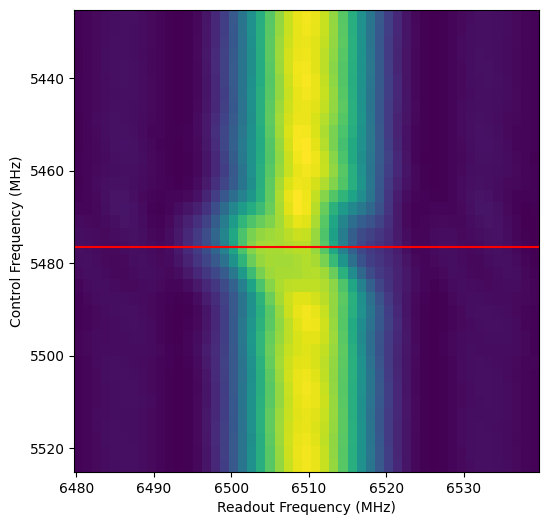

In [11]:
fig, ax = plt.subplots(figsize=(6,6))

plt.imshow(n_photons_all, extent=[freq_sweep.min()/v_Mhz,freq_sweep.max()/v_Mhz,ctrl_sweep.max()/v_Mhz,ctrl_sweep.min()/v_Mhz], aspect='auto')
plt.axhline(ctrl_sweep[18]/v_Mhz, c='r')
plt.xlabel('Readout Frequency (MHz)')
plt.ylabel('Control Frequency (MHz)')

plt.show()

## Time Domain
This section explores time-domain dynamics, specifically Rabi oscillations.

In [12]:
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

def rabi_oscillation(t, omega1, Omega):
    """Rabi oscillation model: P = (omega1^2/Omega^2) * sin^2(Omega*t/2)"""
    return (omega1**2 / Omega**2) * np.sin(Omega * t / 2)**2

def fit_rabi_oscillation(times, probabilities):
    """
    Fit Rabi oscillation data and return parameters with uncertainties
    
    Parameters:
    -----------
    times : array-like
        Time points (typically in μs)
    probabilities : array-like
        Measured excitation probabilities
        
    Returns:
    --------
    dict
        Contains fit parameters, uncertainties, and the fitted curve
    """
    # Initial parameter guesses
    # Estimate Omega from the data by looking at oscillation period
    idx_peaks = np.argwhere(np.diff(np.sign(np.diff(probabilities))) < 0).flatten() + 1
    if len(idx_peaks) >= 2:
        T_estimated = (times[idx_peaks[-1]] - times[idx_peaks[0]]) / (len(idx_peaks) - 1)
        Omega_guess = 2 * np.pi / T_estimated
    else:
        # Fallback if peaks detection fails
        Omega_guess = 2 * np.pi / (times[-1] - times[0]) * 2
    
    omega1_guess = np.sqrt(np.max(probabilities)) * Omega_guess
    
    # Bounds for parameters (lower, upper)
    bounds = ([0, 0], [np.inf, np.inf])
    
    try:
        # Perform the fit with robust error handling
        popt, pcov = curve_fit(
            rabi_oscillation, 
            times, 
            probabilities, 
            p0=[omega1_guess, Omega_guess],
            bounds=bounds,
            maxfev=10000,  # Increase max iterations
            method='trf'   # Trust Region Reflective algorithm (robust)
        )
        
        # Extract parameters and uncertainties
        omega1_fit, Omega_fit = popt
        omega1_err, Omega_err = np.sqrt(np.diag(pcov))
        
        # Generate fitted curve on a finer grid for plotting
        t_fine = np.linspace(min(times), max(times), 1000)
        p_fit = rabi_oscillation(t_fine, omega1_fit, Omega_fit)
        
        return {
            'omega1': omega1_fit,
            'Omega': Omega_fit,
            'omega1_err': omega1_err,
            'Omega_err': Omega_err,
            't_fit': t_fine,
            'p_fit': p_fit,
            'rabi_period': 2*np.pi/Omega_fit,
            'max_probability': (omega1_fit/Omega_fit)**2
        }
        
    except Exception as e:
        print(f"Fitting failed: {e}")
        return None

def plot_rabi_fit(times, probabilities, fit_results):
    """Plot the original data and the fit"""
    plt.figure(figsize=(10, 6))
    plt.scatter(times, probabilities, label='Data', color='blue')
    
    if fit_results:
        plt.plot(fit_results['t_fit'], fit_results['p_fit'], 'r-', label='Fit')
        plt.title(f"Rabi Oscillation Fit\nΩ = {fit_results['Omega']:.3f} ± {fit_results['Omega_err']:.3f}\n"
                 f"ω₁ = {fit_results['omega1']:.3f} ± {fit_results['omega1_err']:.3f}\n"
                 f"Rabi Period = {fit_results['rabi_period']:.3f}")
    
    plt.xlabel('Time')
    plt.ylabel('Excitation Probability')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

In [13]:
import numpy as np
from scipy.optimize import curve_fit
from scipy.signal import find_peaks

def fit_ramsey_oscillation(delays, populations, plot=True, verbose=True):
    """
    Fit Ramsey oscillation data to extract T2* and detuning frequency.
    
    Parameters:
    -----------
    delays : array-like
        Delay times in seconds or microseconds
    populations : array-like
        Measured excited state populations
    plot : bool, optional
        Whether to plot the results
    verbose : bool, optional
        Whether to print the fit results
        
    Returns:
    --------
    dict
        Contains fit parameters, uncertainties, and the fitted curve
    """
    import matplotlib.pyplot as plt
    
    # Define the Ramsey decay model: A*cos(omega*t + phi)*exp(-t/T2) + C
    def ramsey_model(t, A, omega, phi, T2, C):
        return A * np.sin(omega * t + phi) * np.exp(-t / T2) + C
    
    # Initial parameter guesses
    # Try to estimate frequency from peaks in the data
    peaks, _ = find_peaks(populations)
    
    if len(peaks) >= 2:
        # Estimate frequency from peak spacing
        avg_peak_spacing = np.mean(np.diff(delays[peaks]))
        omega_guess = 2 * np.pi / avg_peak_spacing
    else:
        # Fallback if peak detection fails
        omega_guess = 2 * np.pi / (delays[-1] - delays[0]) * 2
    
    A_guess = (np.max(populations) - np.min(populations)) / 2
    C_guess = np.mean(populations)
    T2_guess = (delays[-1] - delays[0]) / 3  # Initial guess for T2*
    phi_guess = 0  # Initial phase guess
    
    # Perform the fit
    try:
        popt, pcov = curve_fit(
            ramsey_model, 
            delays, 
            populations, 
            p0=[A_guess, omega_guess, phi_guess, T2_guess, C_guess],
            bounds=([0, 0, -np.pi, 0, 0], 
                    [np.inf, np.inf, np.pi, np.inf, np.inf]),
            maxfev=10000
        )
        
        A_fit, omega_fit, phi_fit, T2_fit, C_fit = popt
        perr = np.sqrt(np.diag(pcov))
        
        # Generate fitted curve for plotting
        dense_delays = np.linspace(delays.min(), delays.max(), 1000)
        fit_curve = ramsey_model(dense_delays, *popt)
        
        # Convert to more intuitive units if delays are in seconds
        T2_unit = "μs"
        freq_unit = "MHz"
        
        # Check if we should use μs instead
        avg_delay = np.mean(delays)
        T2_fit_display = T2_fit
        T2_err_display = perr[3]
        freq_display = omega_fit / (2 * np.pi)
        freq_err_display = perr[1] / (2 * np.pi)
        
        if verbose:
            print(f"Fit results:")
            print(f"T2* = {T2_fit_display:.3f} ± {T2_err_display:.3f} {T2_unit}")
            # print(f"Detuning = {freq_display:.3f} ± {freq_err_display:.3f} {freq_unit}")
            # print(f"Amplitude = {A_fit:.3f} ± {perr[0]:.3f}")
            # print(f"Phase = {phi_fit:.3f} ± {perr[2]:.3f} rad")
            # print(f"Offset = {C_fit:.3f} ± {perr[4]:.3f}")
        
        if plot:
            plt.figure(figsize=(10, 6))
            plt.plot(delays, populations, 'bo', label='Data')
            plt.plot(dense_delays, fit_curve, 'r-', label='Fit')
            plt.xlabel(f'Delay ({T2_unit})')
            plt.ylabel('Excited state population')
            plt.title(f'Ramsey Oscillation: T2* = {T2_fit_display:.3f} {T2_unit}')
            plt.grid(True, alpha=0.3)
            plt.legend()
            plt.show()
        
        return {
            "T2": T2_fit,
            "T2_err": perr[3],
            "detuning": omega_fit / (2 * np.pi),
            "detuning_err": perr[1] / (2 * np.pi),
            "amplitude": A_fit,
            "amplitude_err": perr[0],
            "phase": phi_fit,
            "phase_err": perr[2],
            "offset": C_fit,
            "offset_err": perr[4],
            "delays": dense_delays,
            "fit": fit_curve,
            "units": {"time": T2_unit, "frequency": freq_unit}
        }
        
    except Exception as e:
        print(f"Fitting error: {e}")
        return None

In [14]:
q_levels = 3

q_op = qt.destroy(q_levels).to("CSR")

q_freq = 5.5 * 1e3 * v_Mhz

EC = 275 * v_Mhz
EJ = (q_freq + EC) ** 2 / 8 / EC


H_Q = scq.Transmon(EC=EC, EJ=EJ, ng=0.0, ncut=100, truncated_dim=q_levels)
H_0 = scq.HilbertSpace([H_Q]).hamiltonian().to('CSR')
q_freq = H_Q.E01()

rho_g = qt.basis(q_levels, 0)
rho_e = qt.basis(q_levels, 1)

In [15]:
ctrl_sweep = np.linspace(q_freq - 10*v_Mhz, q_freq+10*v_Mhz, 32)
plateau_sweep = np.linspace(0,250e-9, 36)

plateau = 30e-9
width = 10e-9

tlist = lambda plateau: np.arange(0,plateau + 2*width, 1e-9)

amp = 10*v_Mhz

H_q_drive = lambda omega_drive, plateau : [amp * (q_op + q_op.dag()), lambda t: np.cos(omega_drive * t) * pulse_env(t, 0, plateau, width)]

In [16]:
output_chevron = np.array(list(
    tqdm(
        Parallel(n_jobs=-1, return_as="generator")(
            delayed(qt.mesolve)(
                [H_0, H_q_drive(omega_q_drive, plateau)]
                ,
                rho_g,
                tlist(plateau),
                c_ops=[],
                e_ops=[rho_g.proj()],
            )
            for omega_q_drive in ctrl_sweep
            for plateau in plateau_sweep
        ),
        total=len(ctrl_sweep)*len(plateau_sweep),
    ))).reshape(len(ctrl_sweep), len(plateau_sweep))

n_photons_chevron = np.array([output_chevron[c,a].expect[0][-1] for c in range(len(ctrl_sweep)) for a in range(len(plateau_sweep))]).reshape(len(ctrl_sweep), len(plateau_sweep))

100%|██████████| 1152/1152 [01:57<00:00,  9.77it/s]


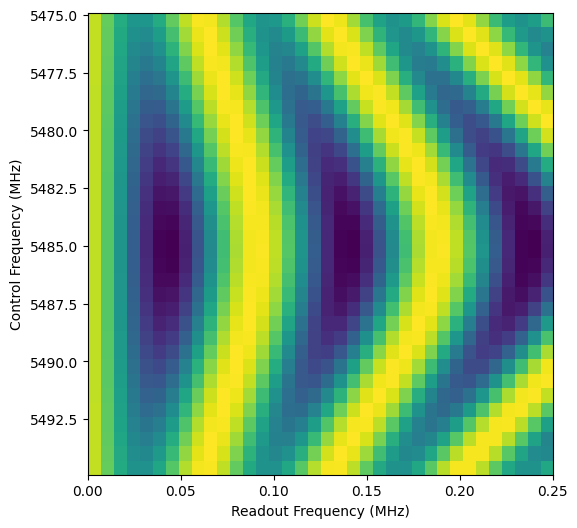

In [17]:
fig, ax = plt.subplots(figsize=(6,6))

plt.imshow(n_photons_chevron, extent=[plateau_sweep.min()*1e6,plateau_sweep.max()*1e6,ctrl_sweep.max()/v_Mhz,ctrl_sweep.min()/v_Mhz], aspect='auto')
plt.xlabel('Readout Frequency (MHz)')
plt.ylabel('Control Frequency (MHz)')

plt.show()

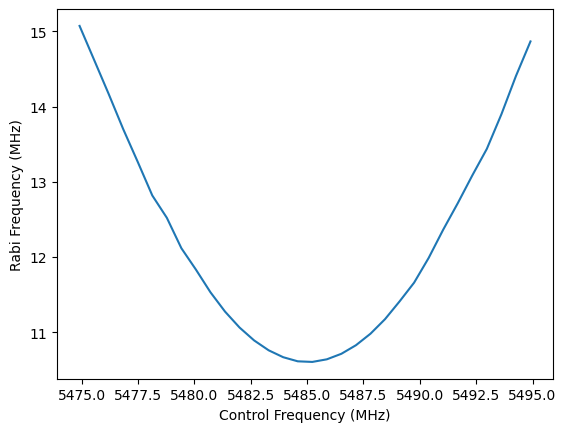

In [18]:
plt.plot(ctrl_sweep/v_Mhz, [fit_rabi_oscillation(plateau_sweep, 1-n_photons_chevron[k])['Omega']/v_Mhz for k in range(len(ctrl_sweep))])
plt.xlabel('Control Frequency (MHz)')
plt.ylabel('Rabi Frequency (MHz)')

best_control_index = np.argmin([fit_rabi_oscillation(plateau_sweep, 1-n_photons_chevron[k])['Omega'] for k in range(len(ctrl_sweep))])

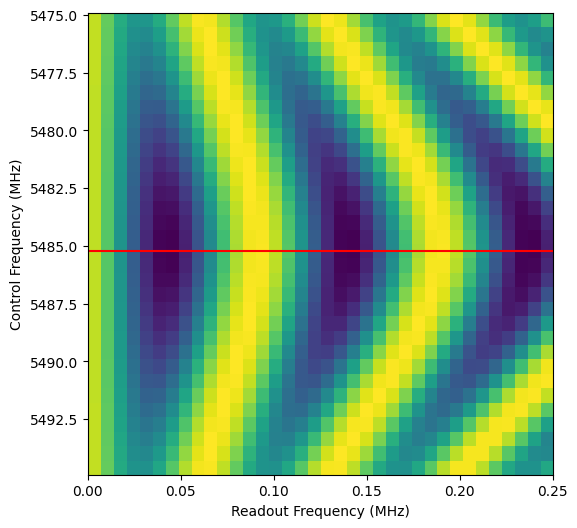

In [19]:
fig, ax = plt.subplots(figsize=(6,6))

plt.imshow(n_photons_chevron, extent=[plateau_sweep.min()*1e6,plateau_sweep.max()*1e6,ctrl_sweep.max()/v_Mhz,ctrl_sweep.min()/v_Mhz], aspect='auto')
plt.axhline(ctrl_sweep[best_control_index]/v_Mhz, c='r')
plt.xlabel('Readout Frequency (MHz)')
plt.ylabel('Control Frequency (MHz)')

plt.show()

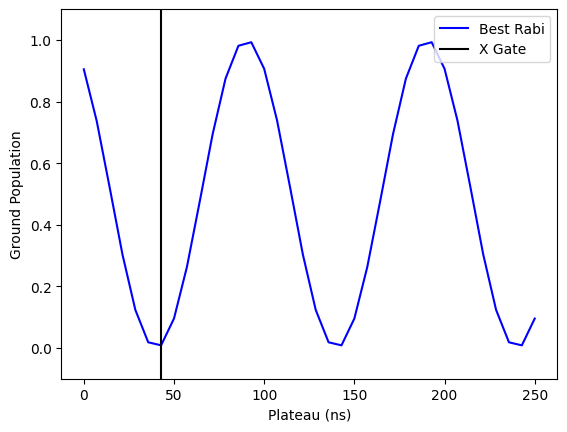

In [20]:
plt.plot(plateau_sweep*1e9, n_photons_chevron[best_control_index], 'b', label= 'Best Rabi')
plt.axvline(1e9*plateau_sweep[n_photons_chevron[best_control_index][:10].argmin()], c='k', label = 'X Gate')
plt.xlabel('Plateau (ns)')
plt.ylabel('Ground Population')
plt.legend()
plt.ylim(-0.1,1.1)
plt.show()


best_plateau_index=n_photons_chevron[best_control_index][:10].argmin()

In [21]:
pi_amp = amp
pi_plateau = plateau_sweep[best_plateau_index]
q_actual_freq = ctrl_sweep[best_control_index]

## Qubit Characterization
In this chapter, we characterize the qubit by measuring its relaxation time (T1) and coherence time (T2*).

### T1 Measurement
This subsection measures the relaxation time (T1) of the qubit, which represents the time it takes for the qubit to return to its ground state.

In [22]:
q_levels = 3

q_op = qt.destroy(q_levels).to("CSR")

q_freq = 5.5 * 1e3 * v_Mhz

EC = 275 * v_Mhz
EJ = (q_freq + EC) ** 2 / 8 / EC


H_Q = scq.Transmon(EC=EC, EJ=EJ, ng=0.0, ncut=100, truncated_dim=q_levels)
H_0 = scq.HilbertSpace([H_Q]).hamiltonian().to('CSR')

rho_g = qt.basis(q_levels, 0)
rho_e = qt.basis(q_levels, 1)

In [23]:
T1 = 100e-6

c_ops = [np.sqrt(1/T1)*q_op]

In [24]:
delay = 300e-6
output_T1 = qt.mesolve(
                H_0
                ,
                rho_e,
                tlist(delay),
                c_ops=c_ops,
                e_ops=[rho_e.proj()], options = dict(progress_bar = 'tqdm')
            )


100%|██████████| 300019/300019 [00:08<00:00, 34523.70it/s]dm/auto.py: 21


In [25]:
from scipy.optimize import curve_fit

def get_t1(e_pop, delay_sweep):
    exponential_decay = lambda t, A, T1, c: A * np.exp(-1 * t / T1) + c

    initial_guess = [1, 35, 3]  # Initial parameter guess for the fit
    popt, pcov = curve_fit(
        exponential_decay,
        delay_sweep,
        e_pop,
        p0=initial_guess,
    )
    t1 = popt[1]
    return t1, popt, pcov


T1 = 100.00 us


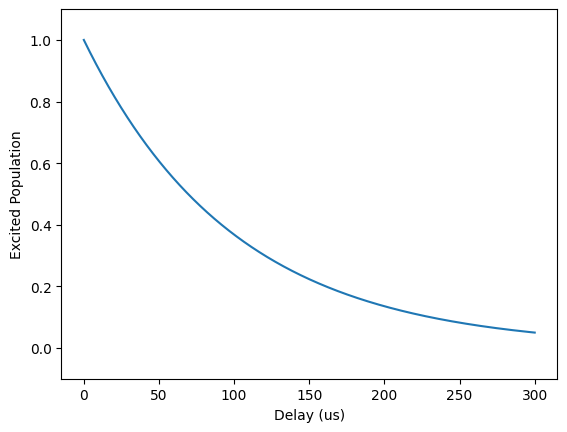

In [26]:
plt.plot(tlist(delay)*1e6, output_T1.expect[0])
plt.xlabel('Delay (us)')
plt.ylabel('Excited Population')
print(f'T1 = {get_t1(output_T1.expect[0], tlist(delay)*1e6)[0]:.2f} us')
plt.ylim(-0.1,1.1)
plt.show()

### T2* Measurement
Here, we measure the coherence time (T2*) of the qubit, which quantifies the decay of quantum superposition due to dephasing.

In [27]:
delay_sweep = np.linspace(0,10e-6,32)
T2_STAR = 10e-6
pi_amp = 10*v_Mhz
c_ops = [np.sqrt(2/T2_STAR)*q_op.dag()*q_op]

X_GATE = lambda pi_amp, omega_drive, t0: [pi_amp * (q_op + q_op.dag()), lambda t: np.cos(omega_drive * t) * pulse_env(t, t0, pi_plateau, width)]


In [28]:
output_T2s = np.array(list(
    tqdm(
        Parallel(n_jobs=-1, return_as="generator")(
            delayed(qt.mesolve)(
                [H_0, X_GATE(pi_amp/2,q_actual_freq+0*v_Mhz,0), X_GATE(pi_amp/2,q_actual_freq+0*v_Mhz,delay)]
                ,
                rho_g.to('CSR'),
                tlist(delay+2*(pi_plateau + 2*width)),
                c_ops=c_ops,
                e_ops=[rho_e.proj(), (rho_e+rho_g).unit().proj()],
                options = dict(store_final_state = True)
            )
            for delay in delay_sweep
        ),
        total=len(delay_sweep),
    )))


100%|██████████| 32/32 [04:13<00:00,  7.93s/it]


Fit results:
T2* = 9.182 ± 0.007 μs


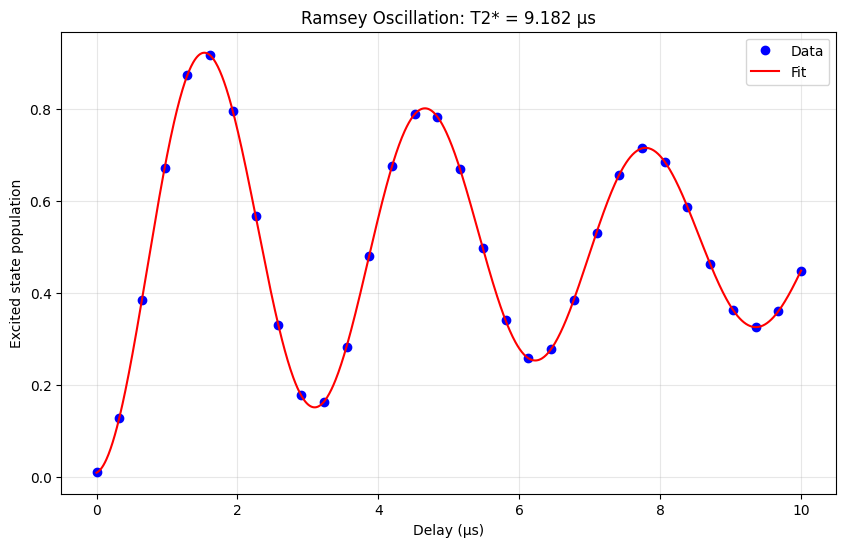

In [29]:
_ = fit_ramsey_oscillation(np.linspace(0,10e-6,32)*1e6, [1-state.expect[0][-1] for state in output_T2s], plot=True, verbose=True)